In [1]:
import glob
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #USE CUDA if gpu is represent
# isGpuAvail = torch.cuda.is_available()

#force on cpu
device=torch.device('cpu')
isGpuAvail=False

In [2]:
#Model
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(x_lstm[:,-1,:]))

In [3]:
#Prediction Function
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize =  transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    #cv2.imwrite('./2.png',image*255)
    return image

def predict(model,img,path = './'):
  fmap,logits = model(img.to('cuda') if isGpuAvail else img.to('cpu'))
  params = list(model.parameters())
  weight_softmax = model.linear1.weight.detach().cpu().numpy()
  logits = sm(logits)
  _,prediction = torch.max(logits,1)
  confidence = logits[:,int(prediction.item())].item()*100
 
  idx = np.argmax(logits.detach().cpu().numpy())
  bz, nc, h, w = fmap.shape
  out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h*w)).T,weight_softmax[idx,:].T)
  predict = out.reshape(h,w)
  predict = predict - np.min(predict)
  predict_img = predict / np.max(predict)
  predict_img = np.uint8(255*predict_img)
  out = cv2.resize(predict_img, (im_size,im_size))
  heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
  img = im_convert(img[:,-1,:,:,:])
  result = heatmap * 0.5 + img*0.8*255
  #cv2.imwrite('/content/1.png',result)
  result1 = heatmap * 0.5/255 + img*0.8
  r,g,b = cv2.split(result1)
  result1 = cv2.merge((r,g,b))
  plt.imshow(result1)
  plt.show()
  print('confidence of prediction:',logits[:,int(prediction.item())].item()*100)
  gc.collect()
  torch.cuda.empty_cache()
  return [int(prediction.item()),confidence]



In [4]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [5]:
class extract_face_video(Dataset): # extracts face from given video for prediction
    def __init__(self,video_names,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        face_detector = MTCNN(device=device) #MTCNN for face detection
        for i,frame in enumerate(self.frame_extract(video_path)):
         
            try:
                face = face_detector.detect(frame)[0][0]
            except:
                continue
            try:              
                left,bottom,right,top=face
                left=int(left)
                bottom=int(bottom)
                right=int(right)
                top=int(top)
                frame=frame[bottom:top,left:right] 
            except:
                pass
           
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
              break
        #print("no of frames",len(frames))
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

['./Face_Crop_Small\\id0_0000.mp4', './Face_Crop_Small\\id1_id0_0000.mp4']


C:\Users\PRANAY\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PRANAY\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


./Face_Crop_Small\id0_0000.mp4


C:\Users\PRANAY\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


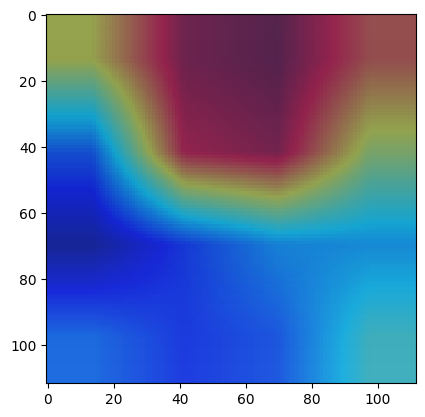

confidence of prediction: 77.74292826652527
2
REAL
./Face_Crop_Small\id1_id0_0000.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


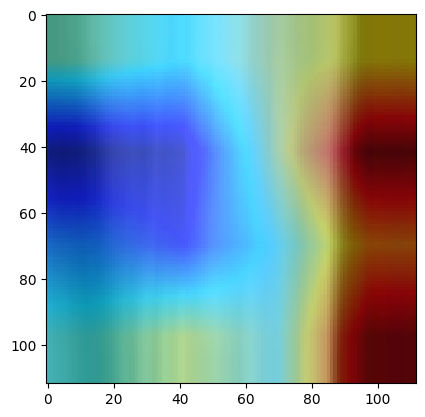

confidence of prediction: 89.64373469352722
3
FAKE
True positive =  1
False positive =  0
False negative =  0
True negative =  1




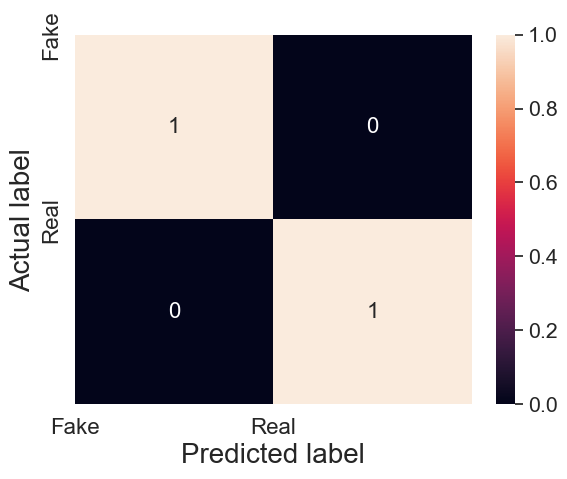

Calculated Accuracy 100.0


In [6]:
import gc
#Code for making prediction
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])


path_to_videos= glob.glob("./Face_Crop_Small/*.mp4")
print(path_to_videos)
# path_to_videos= glob.glob("../Dataset/YouTube-real/*.mp4")
video_dataset = extract_face_video(path_to_videos,sequence_length = 20,transform = train_transforms) #Predict based on first 20 frames

model =Model(2).cuda() if isGpuAvail else Model(2).cpu()
path_to_model = './trained-model-small.pt'
# path_to_model = './trained-model.pt'
model.load_state_dict(torch.load(path_to_model,map_location=device))
model.eval()
true=[]
pred=[]
with torch.no_grad():
    for i in range(0,len(path_to_videos)):
      print(path_to_videos[i])
      prediction = predict(model,video_dataset[i],'./')
      gc.collect() #Avoid memory leak
      
      #For confusion matrix
      trueLabel=path_to_videos[i].split("\\")[-1]
      trueLabel=len(trueLabel.split("_"))
      print(trueLabel)
      pred.append(prediction[0])
      if trueLabel <= 2:
          true.append(1)
      elif trueLabel == 3:
          true.append(0)
    
      if prediction[0] == 1:      
        print("REAL")
      else:
        print("FAKE")

print_confusion_matrix(true,pred)